In [27]:
import pandas as pd
import numpy as np
import cython
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
from CalculateMetrics import calculate_all_metrics

df = pd.read_csv("C:/Users/iwama/Desktop/Osobiste/MSc/put-msc/Endometriosis/endometriosis.csv")
X = df.drop(columns=['target'])
y = df['target'].astype('int')
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [14]:
def run_test(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(name)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("Classification Report - Test:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    labels = ['Class 0', 'Class 1']
    print("Confusion Matrix:")
    print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
    print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
    print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

def run_small_test(model, name, X_train, y_train, X_test, y_test, verbose=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    if verbose:
        print("================================")
        print(f"{name} - Accuracy: {acc:.4f}, ROC AUC: {roc:.4f}, F1 Score: {f1:.4f}")

    return acc, roc, f1

XGBoost Classifier
Accuracy: 0.8327
ROC AUC: 0.7752
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       217
           1       0.54      0.28      0.37        46

    accuracy                           0.83       263
   macro avg       0.70      0.62      0.64       263
weighted avg       0.81      0.83      0.81       263

Confusion Matrix:
                    Class 0             Class 1             
Class 0             206                 11                    # True Negative (TN), False Positive (FP)
Class 1             33                  13                    # False Negative (FN), True Positive (TP)


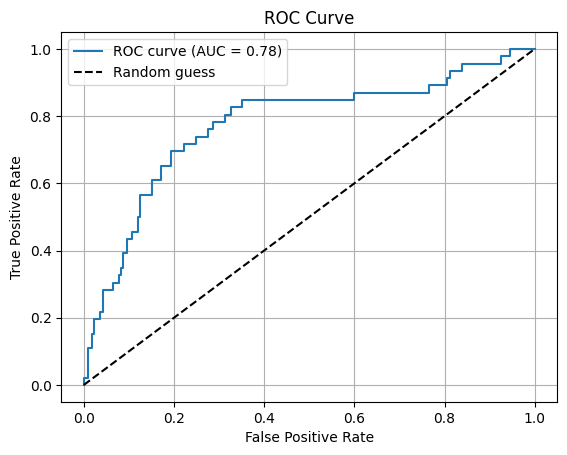

In [4]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
run_test(xgb_model, "XGBoost Classifier", X_train, y_train, X_test, y_test)

Ender Classifier Modified
Accuracy: 0.8251
ROC AUC: 0.7990
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       217
           1       0.50      0.39      0.44        46

    accuracy                           0.83       263
   macro avg       0.69      0.65      0.67       263
weighted avg       0.81      0.83      0.82       263

Confusion Matrix:
                    Class 0             Class 1             
Class 0             199                 18                    # True Negative (TN), False Positive (FP)
Class 1             28                  18                    # False Negative (FN), True Positive (TP)


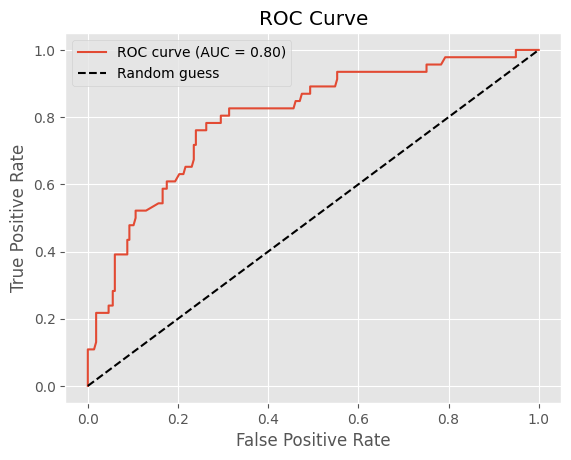

In [25]:
from EnderClassifierModified import EnderClassifier as ECM

ecm = ECM(verbose=False, n_rules=33, use_gradient=False)
run_test(ecm, "Ender Classifier Modified", X_train, y_train, X_test, y_test)

In [19]:
results = []

for n in range(8, 40):
    ecm = ECM(verbose=False, n_rules=n, use_gradient=False)
    acc, roc, f1 = run_small_test(ecm, f"ECM False (n_rules={n})", X_train, y_train, X_test, y_test, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
8 rules, ACC: 0.8555, ROC: 0.7674, F1: 0.5000
Best ROC AUC:
33 rules, ACC: 0.8251, ROC: 0.7990, F1: 0.4390
Best F1 Score:
11 rules, ACC: 0.8517, ROC: 0.7683, F1: 0.5301


Ender Classifier Modified with Gradient
Accuracy: 0.8593
ROC AUC: 0.7836
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       217
           1       0.70      0.35      0.46        46

    accuracy                           0.86       263
   macro avg       0.79      0.66      0.69       263
weighted avg       0.84      0.86      0.84       263

Confusion Matrix:
                    Class 0             Class 1             
Class 0             210                 7                     # True Negative (TN), False Positive (FP)
Class 1             30                  16                    # False Negative (FN), True Positive (TP)


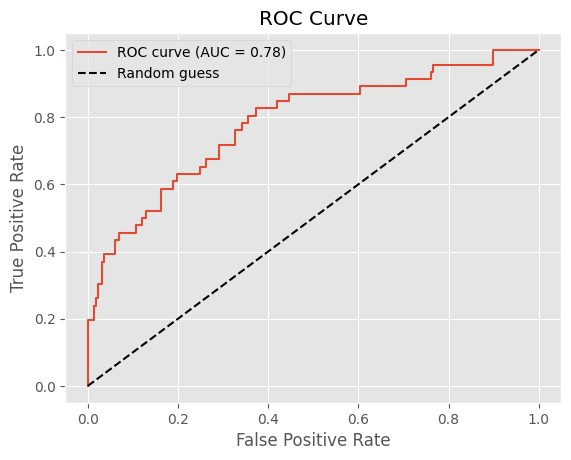

In [28]:
ecm = ECM(verbose=False, n_rules=35, use_gradient=True)
run_test(ecm, "Ender Classifier Modified with Gradient", X_train, y_train, X_test, y_test)

In [23]:
results = []

for n in range(36, 50):
    ecm = ECM(verbose=False, n_rules=n, use_gradient=True)
    acc, roc, f1 = run_small_test(ecm, f"ECM True (n_rules={n})", X_train, y_train, X_test, y_test, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
36 rules, ACC: 0.8631, ROC: 0.7843, F1: 0.4857
Best ROC AUC:
39 rules, ACC: 0.8555, ROC: 0.7873, F1: 0.4412
Best F1 Score:
47 rules, ACC: 0.8631, ROC: 0.7835, F1: 0.5135


Ender Classifier Bounded Fast
Accuracy: 0.8441
ROC AUC: 0.8086
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       217
           1       0.59      0.37      0.45        46

    accuracy                           0.84       263
   macro avg       0.73      0.66      0.68       263
weighted avg       0.83      0.84      0.83       263

Confusion Matrix:
                    Class 0             Class 1             
Class 0             205                 12                    # True Negative (TN), False Positive (FP)
Class 1             29                  17                    # False Negative (FN), True Positive (TP)


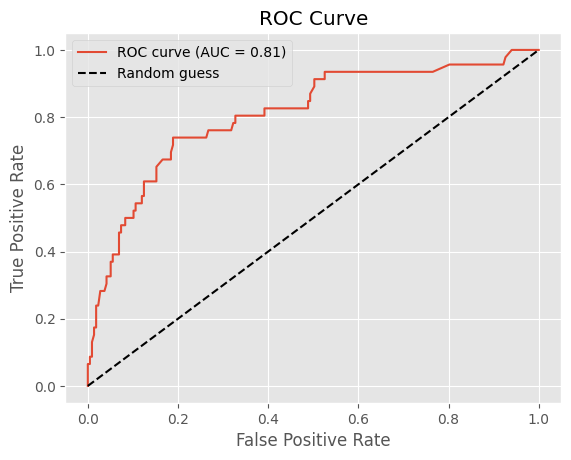

In [35]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF

ecbf = ECBF(verbose=False, n_rules=14, use_gradient=False)
run_test(ecbf, "Ender Classifier Bounded Fast", X_train, y_train, X_test, y_test)

In [34]:
results = []

for n in range(14, 40):
    ecm = ECBF(verbose=False, n_rules=n, use_gradient=False)
    acc, roc, f1 = run_small_test(ecm, f"EBF False (n_rules={n})", X_train, y_train, X_test, y_test, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
15 rules, ACC: 0.8479, ROC: 0.8001, F1: 0.4444
Best ROC AUC:
14 rules, ACC: 0.8441, ROC: 0.8086, F1: 0.4533
Best F1 Score:
14 rules, ACC: 0.8441, ROC: 0.8086, F1: 0.4533


Ender Classifier Bounded Fast Gradient
Accuracy: 0.8289
ROC AUC: 0.7695
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       217
           1       0.52      0.33      0.40        46

    accuracy                           0.83       263
   macro avg       0.69      0.63      0.65       263
weighted avg       0.81      0.83      0.81       263

Confusion Matrix:
                    Class 0             Class 1             
Class 0             203                 14                    # True Negative (TN), False Positive (FP)
Class 1             31                  15                    # False Negative (FN), True Positive (TP)


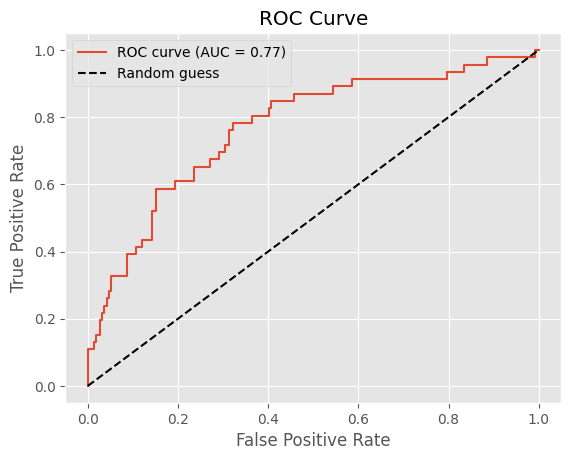

In [40]:
ecbf = ECBF(verbose=False, n_rules=46, use_gradient=True)
run_test(ecbf, "Ender Classifier Bounded Fast Gradient", X_train, y_train, X_test, y_test)

In [38]:
results = []

for n in range(17, 50):
    ecm = ECBF(verbose=False, n_rules=n, use_gradient=True)
    acc, roc, f1 = run_small_test(ecm, f"EBF True (n_rules={n})", X_train, y_train, X_test, y_test, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
17 rules, ACC: 0.8441, ROC: 0.7450, F1: 0.4384
Best ROC AUC:
46 rules, ACC: 0.8289, ROC: 0.7695, F1: 0.4000
Best F1 Score:
17 rules, ACC: 0.8441, ROC: 0.7450, F1: 0.4384


In [37]:
from EnderClassifierBoundedFast import EnderClassifier

print("ENDER CLASSIFIER BOUNDED FAST")
ender = EnderClassifier(verbose=True, n_rules=14, use_gradient=False)
ender.fit(X_train, y_train)

ENDER CLASSIFIER BOUNDED FAST
Default rule: [ 0.49790622 -0.49790622]
####################################################################################
Rule: 1
Default Rule: MSE = 0.18340558976477644
Squared errors calculated in 0.0000 seconds
	sex_pain in [-1e+308, 1.5]
	defecation_pain_during in [-1e+308, 1.5]
	chronic_pain_level in [-1e+308, 3.5]
	family_endo in [-1e+308, 0.5]
	menstruation_lenght in [-1e+308, 27.0]
	stomach_ache_apart in [0.5, 1e+308]
	abdominal_pressure_apart in [0.5, 1e+308]
	cycle in [-1e+308, 45.0]
=> vote for class 0 with weight 0.5681012197701224
[np.float64(0.5681012197701224), np.float64(-0.5681012197701224)]

####################################################################################
Rule: 2
Default Rule: MSE = 0.18340558976477644
Rule 0: MSE = 0.17522474124544135
Squared errors calculated in 0.0000 seconds
	sex_pain_level in [3.5, 1e+308]
	chronic_pain_level in [0.5, 1e+308]
	menstruation_pain in [5.5, 1e+308]
	age in [23.5, 1e+308]
	smoking_t

Bounded Ender Classifier
Accuracy: 0.8384
ROC AUC: 0.8413
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       150
           1       0.75      0.50      0.60        48

    accuracy                           0.84       198
   macro avg       0.80      0.72      0.75       198
weighted avg       0.83      0.84      0.83       198

Confusion Matrix:
                    No Endometriosis    Endometriosis       
No Endometriosis    142                 8                     # True Negative (TN), False Positive (FP)
Endometriosis       24                  24                    # False Negative (FN), True Positive (TP)


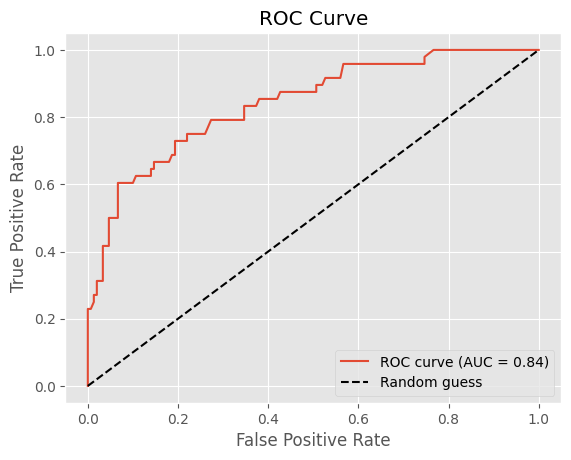

In [38]:
y_train_pred = ender.predict(X_train)
y_test_pred = ender.predict(X_test)

train_metrics = calculate_all_metrics(y_train, y_train_pred)
test_metrics = calculate_all_metrics(y_test, y_test_pred)

y_pred = np.array([np.argmax(pred) for pred in y_test_pred])

print("Bounded Ender Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
y_probs = ender.predict_proba(X_test)
print(f"ROC AUC: {roc_auc_score(y_test, y_probs[:, 1]):.4f}")
print("Classification Report - Test:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['No Endometriosis', 'Endometriosis']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
auc = roc_auc_score(y_test, y_probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [20]:
from EnderClassifierModified import EnderClassifier

print("EnderClassifierModified")
ender = EnderClassifier(verbose=True, n_rules=16, use_gradient=False)
ender.fit(X_train, y_train)

EnderClassifierModified
Default rule: [np.float64(0.4979062213548282), np.float64(-0.4979062213548282)]
####################################################################################
Rule: 1
	sex_pain in [-1e+308, 1.5]
	defecation_pain_during in [-1e+308, 1.5]
	chronic_pain_level in [-1e+308, 3.5]
	family_endo in [-1e+308, 0.5]
	menstruation_lenght in [-1e+308, 27.0]
	stomach_ache_apart in [0.5, 1e+308]
	abdominal_pressure_apart in [0.5, 1e+308]
	cycle in [-1e+308, 45.0]
=> vote for class 0 with weight 0.5681012197701224
[np.float64(0.5681012197701224), np.float64(-0.5681012197701224)]

####################################################################################
Rule: 2
	sex_pain_level in [3.5, 1e+308]
	chronic_pain_level in [0.5, 1e+308]
	menstruation_pain in [5.5, 1e+308]
	age in [23.5, 1e+308]
	smoking_time in [-1e+308, 23.5]
	height in [157.0, 1e+308]
	weight in [-1e+308, 114.5]
	first_menstruation in [6.5, 1e+308]
	alcohol_units in [-1e+308, 8.05]
=> vote for class 1

Bounded Ender Classifier
Accuracy: 0.8232
ROC AUC: 0.8058
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       150
           1       0.68      0.52      0.59        48

    accuracy                           0.82       198
   macro avg       0.77      0.72      0.74       198
weighted avg       0.81      0.82      0.81       198

Confusion Matrix:
                    No Endometriosis    Endometriosis       
No Endometriosis    138                 12                    # True Negative (TN), False Positive (FP)
Endometriosis       23                  25                    # False Negative (FN), True Positive (TP)


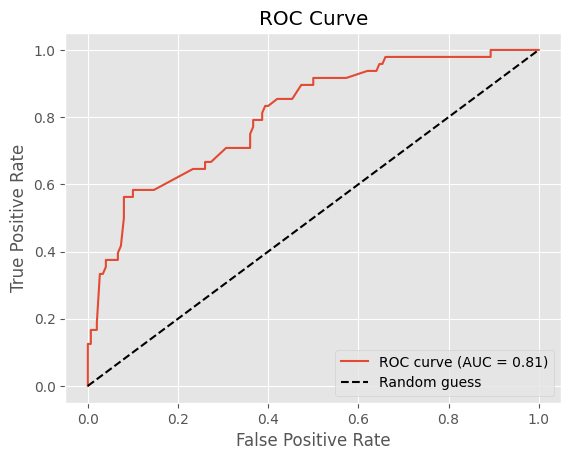

In [21]:
y_train_pred = ender.predict(X_train)
y_test_pred = ender.predict(X_test)

train_metrics = calculate_all_metrics(y_train, y_train_pred)
test_metrics = calculate_all_metrics(y_test, y_test_pred)

y_pred = np.array([np.argmax(pred) for pred in y_test_pred])

print("Bounded Ender Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
y_probs = ender.predict_proba(X_test)
print(f"ROC AUC: {roc_auc_score(y_test, y_probs[:, 1]):.4f}")
print("Classification Report - Test:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['No Endometriosis', 'Endometriosis']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
auc = roc_auc_score(y_test, y_probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

XGBoost Classifier
Accuracy: 0.8182
ROC AUC: 0.8283
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       150
           1       0.65      0.54      0.59        48

    accuracy                           0.82       198
   macro avg       0.76      0.72      0.74       198
weighted avg       0.81      0.82      0.81       198

Confusion Matrix:
                    No Endometriosis    Endometriosis       
No Endometriosis    136                 14                    # True Negative (TN), False Positive (FP)
Endometriosis       22                  26                    # False Negative (FN), True Positive (TP)


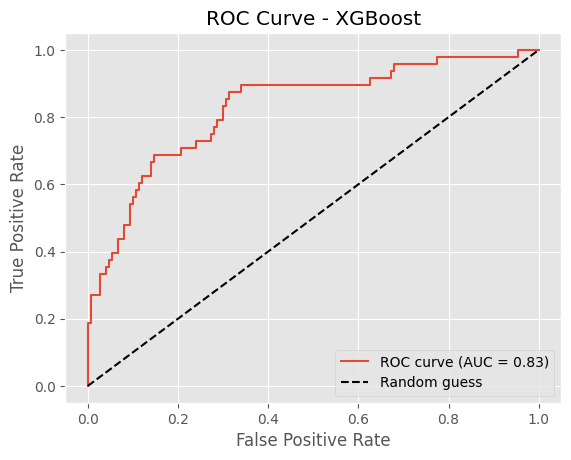

In [34]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

train_metrics_xgb = calculate_all_metrics(y_train, y_train_pred_xgb)
test_metrics_xgb = calculate_all_metrics(y_test, y_test_pred_xgb)

print("XGBoost Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.4f}")
y_probs_xgb = xgb_model.predict_proba(X_test)
print(f"ROC AUC: {roc_auc_score(y_test, y_probs_xgb[:, 1]):.4f}")
print("Classification Report - Test:")
print(classification_report(y_test, y_test_pred_xgb))
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm_xgb[0, 0]:<20}{cm_xgb[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm_xgb[1, 0]:<20}{cm_xgb[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb[:, 1])
auc_xgb = roc_auc_score(y_test, y_probs_xgb[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f"ROC curve (AUC = {auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [66]:
# ENDER = ECBF
ENDER = ECM

# for n in [3,5,7,9,12,15,18,20]:
for n in range(7,15):
    print(f"Testing with n_rules={n}")
    ender = ENDER(verbose=False, n_rules=n, use_gradient=True)
    ender.fit(X_train, y_train)
    y_pred = ender.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_probs = ender.predict_proba(X_test)
    print(f"n_rules={n}, Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"n_rules={n}, ROC AUC: {roc_auc_score(y_test, y_probs[:, 1]):.4f}")
    print("================================")

Testing with n_rules=7
n_rules=7, Accuracy: 0.7879
n_rules=7, ROC AUC: 0.7809
Testing with n_rules=8
n_rules=8, Accuracy: 0.7879
n_rules=8, ROC AUC: 0.7883
Testing with n_rules=9
n_rules=9, Accuracy: 0.8030
n_rules=9, ROC AUC: 0.7919
Testing with n_rules=10
n_rules=10, Accuracy: 0.7980
n_rules=10, ROC AUC: 0.7844
Testing with n_rules=11
n_rules=11, Accuracy: 0.7980
n_rules=11, ROC AUC: 0.7957
Testing with n_rules=12
n_rules=12, Accuracy: 0.7929
n_rules=12, ROC AUC: 0.7817
Testing with n_rules=13
n_rules=13, Accuracy: 0.7980
n_rules=13, ROC AUC: 0.7812
Testing with n_rules=14
n_rules=14, Accuracy: 0.7828
n_rules=14, ROC AUC: 0.7803
